<a href="https://colab.research.google.com/github/sonyharianto1991/multicriteria_healthcheck/blob/main/02_single_metric_confidence_ratio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-Metric Monitoring — Confidence Ratio

Notebook ini fokus ke **single metric** (Confidence Ratio) dengan menjalankan beberapa skenario degradasi.

In [1]:
# (Opsional) Install dependencies jika jalan di Colab
# !pip install -q torch torchvision scikit-learn tqdm numpy pandas matplotlib pillow scipy

import os, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import ImageEnhance, ImageFilter, Image


## 1) Load Baseline Model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 2
MODEL_PATH = "mobilenet_baseline.pth"  # pastikan file ini ada

model = models.mobilenet_v3_small(weights=None)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device).eval()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 2) Baseline Loader (Reference Distribution)

In [8]:
DATA_DIR = "/content/drive/MyDrive/TESIS/dataset"  # TODO sesuaikan
BASELINE_DIR = os.path.join(DATA_DIR, "test")     # gunakan test sebagai baseline reference

IMG_SIZE = 224
BATCH_SIZE = 32

base_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

baseline_ds = datasets.ImageFolder(BASELINE_DIR, transform=base_tfms)
baseline_loader = DataLoader(baseline_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = baseline_ds.classes
class_names


['1', '2']

## 3) Inference Collector (Probabilities + Latency)

In [9]:
@torch.no_grad()
def run_inference_collect(model, dataloader, device):
    model.eval()
    all_probs=[]
    lat_ms=[]
    for x,_ in tqdm(dataloader, desc="infer", leave=False):
        x = x.to(device)
        t0 = time.time()
        logits = model(x)
        torch.cuda.synchronize() if device.type == "cuda" else None
        t1 = time.time()
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        all_probs.append(probs)
        lat_ms.append((t1 - t0) * 1000.0)
    all_probs = np.vstack(all_probs)
    lat_ms = np.array(lat_ms)
    return all_probs, lat_ms


## 4) Hitung Confidence Ratio untuk Baseline

In [10]:
base_probs, base_lat_ms = run_inference_collect(model, baseline_loader, device)
base_max_conf = base_probs.max(axis=1)  # max softmax per sample
base_mean_conf = float(base_max_conf.mean())

print("Baseline mean(max_conf):", base_mean_conf)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


infer:   0%|          | 0/3 [00:00<?, ?it/s]

Baseline mean(max_conf): 0.9588435292243958


## 5) Definisi Skenario Degradasi

Catatan: implementasi dibuat sederhana (PIL) agar mudah dipahami & diubah.

In [12]:
# Helper transform wrappers (PIL -> PIL) lalu masuk ke base_tfms
class PILLighting:
    def __init__(self, factor: float):
        self.factor = factor
    def __call__(self, img):
        return ImageEnhance.Brightness(img).enhance(self.factor)

class PILBlur:
    def __init__(self, radius: float):
        self.radius = radius
    def __call__(self, img):
        return img.filter(ImageFilter.GaussianBlur(radius=self.radius))

class PILJPEG:
    def __init__(self, quality: int):
        self.quality = int(quality)
    def __call__(self, img):
        # simulate JPEG recompress in-memory
        import io
        buf = io.BytesIO()
        img.save(buf, format="JPEG", quality=self.quality)
        buf.seek(0)
        return Image.open(buf).convert("RGB")

class PILGaussianNoise:
    def __init__(self, sigma: float):
        self.sigma = float(sigma)
    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        noise = np.random.normal(0, self.sigma, size=arr.shape).astype(np.float32)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(arr)

# Compose: degradasi (PIL) -> tensor normalize
def make_scenario_tfms(pil_aug):
    return transforms.Compose([
        pil_aug,
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])


## 5.1) Preview: Visual Comparison of Degradation Scenarios

Visualisasi berikut menampilkan perbandingan antara gambar asli dengan 4 skenario degradasi:
- **Lighting**: Penurunan brightness (factor=0.1)
- **Blur**: Gaussian blur (radius=2.0)  
- **Compression**: JPEG compression (quality=25)
- **Noise**: Gaussian noise (sigma=15.0)

In [ ]:
# Preview: Comparison between Original vs Degradation Scenarios
# Load a few sample images to visualize the degradation effects
import random

# Create a simple transform for original images (no degradation, just resize for display)
preview_base_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
])

# Load dataset without normalization for visualization
preview_ds = datasets.ImageFolder(BASELINE_DIR, transform=preview_base_tfm)

# Select random samples to display
num_samples = 4
indices = random.sample(range(len(preview_ds)), num_samples)

# Create subplot: 1 column for original + 4 columns for degradations = 5 columns total
fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))

degradation_list = [
    ("Lighting", PILLighting(factor=0.1)),
    ("Blur", PILBlur(radius=2.0)),
    ("Compression", PILJPEG(quality=25)),
    ("Noise", PILGaussianNoise(sigma=15.0)),
]

for row, idx in enumerate(indices):
    # Load original image
    orig_img, label = preview_ds[idx]
    class_name = preview_ds.classes[label]
    
    # Show original
    axes[row, 0].imshow(orig_img)
    axes[row, 0].set_title(f"Original\n{class_name}", fontsize=10)
    axes[row, 0].axis("off")
    
    # Show each degradation
    for col, (deg_name, deg_transform) in enumerate(degradation_list, start=1):
        degraded_img = deg_transform(orig_img)
        axes[row, col].imshow(degraded_img)
        axes[row, col].set_title(f"{deg_name}\n{class_name}", fontsize=10)
        axes[row, col].axis("off")

plt.suptitle("Degradation Scenarios Comparison", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

## 6) Jalankan Beberapa Skenario (Single Metric)

In [13]:
scenarios = {
    "Lighting Degradation": make_scenario_tfms(PILLighting(factor=0.1)),
    "Blur Degradation": make_scenario_tfms(PILBlur(radius=2.0)),
    "Compression (JPEG)": make_scenario_tfms(PILJPEG(quality=25)),
    "Gaussian Noise": make_scenario_tfms(PILGaussianNoise(sigma=15.0)),
}

results=[]
for scen_name, tfms in scenarios.items():
    scen_ds = datasets.ImageFolder(BASELINE_DIR, transform=tfms)
    scen_loader = DataLoader(scen_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    probs, lat_ms = run_inference_collect(model, scen_loader, device)
    max_conf = probs.max(axis=1)
    mean_conf = float(max_conf.mean())
    conf_ratio = mean_conf / base_mean_conf if base_mean_conf > 0 else float("nan")

    results.append({
        "Scenario": scen_name,
        "Baseline Mean Conf": base_mean_conf,
        "Scenario Mean Conf": mean_conf,
        "Confidence Ratio": conf_ratio,
        "P95 Latency (ms)": float(np.percentile(lat_ms, 95)),
    })

df_single = pd.DataFrame(results).sort_values("Confidence Ratio")
df_single


infer:   0%|          | 0/3 [00:00<?, ?it/s]

infer:   0%|          | 0/3 [00:00<?, ?it/s]

infer:   0%|          | 0/3 [00:00<?, ?it/s]

infer:   0%|          | 0/3 [00:00<?, ?it/s]

,Scenario,Baseline Mean Conf,Scenario Mean Conf,Confidence Ratio,P95 Latency (ms)
1,Blur Degradation,0.958844,0.922400,0.961992,584.120584
3,Gaussian Noise,0.958844,0.924917,0.964617,940.345311
2,Compression (JPEG),0.958844,0.940754,0.981134,717.898273
0,Lighting Degradation,0.958844,0.957125,0.998208,560.904264


## 7) Status Threshold (Single Metric)

In [16]:
# Threshold sederhana (silakan sesuaikan dengan tesis)
# - Healthy   : ratio >= 0.95
# - Degraded  : 0.85 <= ratio < 0.95
# - Critical  : ratio < 0.85
def status_from_ratio(r: float) -> str:
    if r >= 0.80:
        return "Healthy"
    if r >= 0.60:
        return "Degraded"
    return "Critical"

df_single["Status"] = df_single["Confidence Ratio"].apply(status_from_ratio)
df_single


,Scenario,Baseline Mean Conf,Scenario Mean Conf,Confidence Ratio,P95 Latency (ms),Status
1,Blur Degradation,0.958844,0.922400,0.961992,584.120584,Healthy
3,Gaussian Noise,0.958844,0.924917,0.964617,940.345311,Healthy
2,Compression (JPEG),0.958844,0.940754,0.981134,717.898273,Healthy
0,Lighting Degradation,0.958844,0.957125,0.998208,560.904264,Healthy


## 8) (Opsional) Visualisasi Confidence Ratio

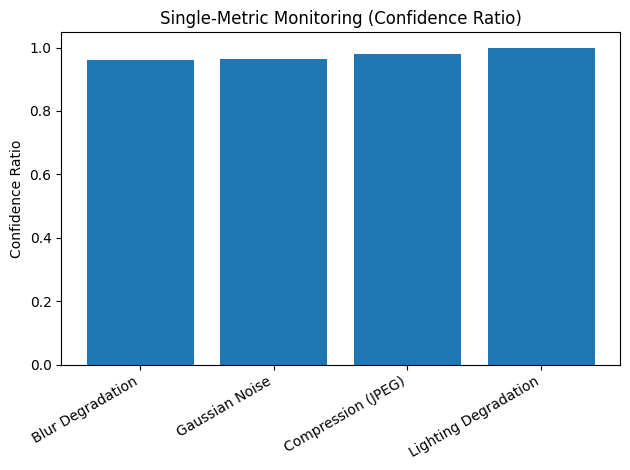

In [15]:
fig = plt.figure()
plt.bar(df_single["Scenario"], df_single["Confidence Ratio"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Confidence Ratio")
plt.title("Single-Metric Monitoring (Confidence Ratio)")
plt.tight_layout()
plt.show()
